## Zillow Clustering Project
By: Scott Schmidl, Data Scientist
01//2022

### Goal
The goal of this project is to discover potential drivers for the log error and from those drivers make predictions about log error.

### Description
We want to find drivers of log error with the hopes of reducing future log errors leading to smaller differences between log(zestimate) and log(sale price)

### Initial Questions
<p>1) Does there appear to be some colinearity between columns?</p>
<p>2) Is there a linear relationship between home size and log error?</p>
<p>3) How does the mean log error compare between county?</p>
<p>4) Is there a linear relationship between tax amount and log error?</p>

### Data Dictionary
<table>
<thead><tr>
<th>Target</th>
<th>Meaning</th>
</tr>
</thead>
<tbody>
<tr>
<td>log_error</td>
<td>log(Zestimate) – log(sale price)</td>
</tr>
</tbody>
</table>
<p></p>
<table>
<thead><tr>
<th>Variable</th>
<th>Meaning</th>
</tr>
</thead>
<tbody>
<tr>
<td>parcel_id</td>
<td>unique identifier for parcels (lots)</td>
</tr>
<tr>
<td>bathroom_count</td>
<td>number of bathrooms in home including fractional bathrooms</td>
</tr>
<tr>
<td>bedroom_count</td>
<td>number of bedrooms in home</td>
</tr>
<tr>
<td>home_size_square_feet</td>
<td>calculated total finished living area of the home</td>
</tr>
<tr>
<td>fips</td>
<td>Federal Information Processing Standard code -  see https://en.wikipedia.org/wiki/FIPS_county_code for more details</td>
</tr>
<tr>
<td>garage_car_count</td>
<td>total number of garages on the lot including an attached garage</td>
</tr>

<tr>
<td>latitude</td>
<td>latitude of the middle of the parcel multiplied by 10e6</td>
</tr>
<tr>
<td>longitude</td>
<td>longitude of the middle of the parcel multiplied by 10e6</td>
</tr>
<tr>
<td>lot_size_square_feet</td>
<td>area of the lot in square feet</td>
</tr>
<tr>
<td>raw_census_tract_and_block</td>
<td>census tract and block ID combined - also contains blockgroup assignment by extension</td>
</tr>
<tr>
<td>region_id_city</td>
<td>city in which the property is located (if any)</td>
</tr>
<tr>
<td>region_id_county</td>
<td>county in which the property is located</td>
</tr>
<tr>
<td>region_id_zip</td>
<td>zip code in which the property is located</td>
</tr>
<tr>
<td>room_count</td>
<td>total number of rooms in the principal residence</td>
</tr>
<tr>
<td>year_built</td>
<td>the Year the principal residence was built</td>
</tr>
<tr>
<td>structure_tax_value_price</td>
<td>the assessed value of the built structure on the parcel</td>
</tr>
<tr>
<td>home_price</td>
<td>the total tax assessed value of the parcel</td>
</tr>
<tr>
<td>assessment_year</td>
<td>the year of the property tax assessment</td>
</tr>
<tr>
<td>land_tax_value_price</td>
<td>the assessed value of the land area of the parcel</td>
</tr>
<tr>
<td>tax_amount</td>
<td>the total property tax assessed for that assessment year</td>
</tr>
<tr>
<td>census_tract_and_block</td>
<td>census tract and block ID combined - also contains blockgroup assignment by extension</td>
</tr>
<tr>
<td>transaction_date</td>
<td>date home was purchased</td>
</tr>
<tr>
<td>county</td>
<td>county name of where the home resides</td>
</tr>
</tbody>
</table>

### Acquiring Zillow
- To acquire the Zillow data, we used the Zillow database in our MySQL server, and selected several columns that hold information regarding taxes, design, and location. Please see acquire.py for full query details.
- For this project the acquire module was imported into the prepare module for simplification.

In [1]:
# Below code is what is used in the prepare module to acquire the data before preparing
# zillow = Acquire().get_zillow_data()

### Preparing Zillow
- Filtered by single use, bedrooms, bathrooms, units, and home size.
- Missing values were removed if the column or row met a threshold.
- Missing values in lot size were filled the mean.
- Certain columns were droppped if they were not deemed helpful.
- Outliers were removed by tax value dollar and home size.
- Feature Engineering was perfomed to create the county column based off of the fips columns.
- More missing values were dropped.
- Column names were changed for readability.
- Column data types were changed to coincide with observations they held.

In [2]:
# Import repare and pandas module
import pandas as pd
from prepare import Prepare
from split_get_scale import SplitGetScale
import warnings
warnings.filterwarnings('ignore')

# Acquire and Prepare zillow data
zillow = Prepare().wrangle_zillow()

# Instantiate SplitGetScale class
sgs = SplitGetScale()

# Get train, validate test
train, validate, test = sgs.split(zillow)

# Get X, y for later use in modeling
cols_drop = ["parcel_id", "fips", "latitude", "longitude", "raw_census_tract_and_block", "region_id_city", "region_id_county", "region_id_zip", "structure_tax_value_price", "tax_value_dollar_count", "assessment_year", "land_tax_value_price", "census_tract_and_block", "transaction_date", "log_error"]
(X_train_no_clust, y_train_no_clust), (X_validate_no_clust, y_validate_no_clust), (X_test_no_clust, y_test_no_clust) = sgs.get_Xy(train, validate, test, ["county"], cols_drop)

### The Issue

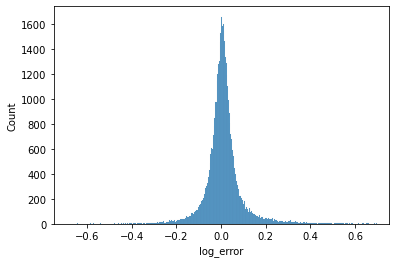

In [3]:
# Import visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# import scipy.stats for statistical tests
from scipy.stats import pearsonr, ttest_ind

# Plot histogram to visualization our target: log error
sns.histplot(data=train["log_error"])
plt.xlim(-.75, .75);

#### Take Away
- While this histogram shows the log error quite tightly around 0, we are hoping to reduce the log error even more to help Zillow make even better approximations of a home's market value (Zestimate).

### Exploratory Data Analysis
- Signifcance Level for each statistical test will be 0.05.

#### Question 1
<p>Does there appear to be some colinearity between columns?</p>

1) Searching for colinearity between tax related columns

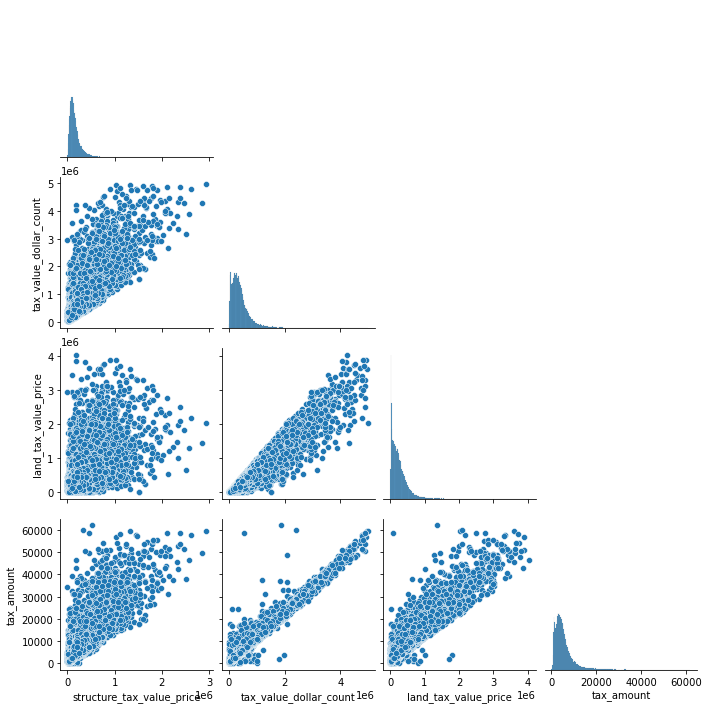

In [4]:
# Make a pairplot to view linear relationships for tax related features
cols = ["structure_tax_value_price", "tax_value_dollar_count", "land_tax_value_price", "tax_amount"]
sns.pairplot(data=train, vars=cols, corner=True);

#### Take Away
- Appears to be a linear relationship between most of the tax related columns

2) Searching for colinearity between house design attributes

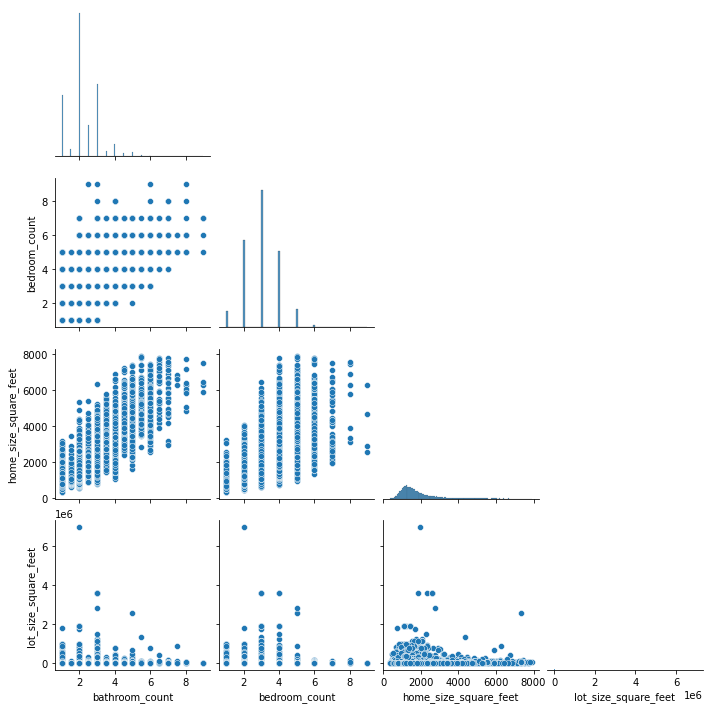

In [5]:
# Make a pairplot to view linear relationships for design related features
cols = ["bathroom_count", "bedroom_count", "home_size_square_feet", "lot_size_square_feet"]
sns.pairplot(data=train, vars=cols, corner=True);

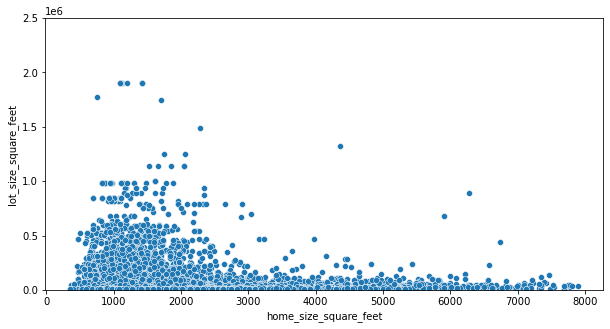

In [6]:
# Better view of the relationship between home size and lot size
plt.figure(figsize=(10,5))
plt.ylim(0, 2.5e6)
sns.scatterplot(x="home_size_square_feet", y="lot_size_square_feet", data=train);

#### Take Away
- Appears to be some linear relationship between home size and bedrooms, home size and bathroom, but interestly there doesn't appear to be one between home size and lot size

#### Question 2
<p>Is there a linear relationship between home size and log error?</p>

- $H_0$: home_size and log_error are not linearly related.
-  $H_a$: home_size and log_error are linearly related.

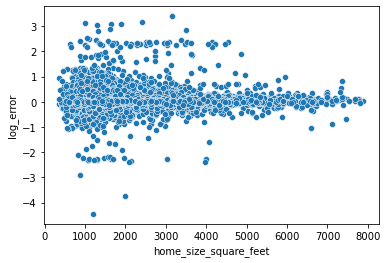

In [7]:
# Plot of home size and log error
sns.scatterplot(x="home_size_square_feet", y="log_error", data=train);

In [8]:
# get statistical test results from pearsonr
r, p = pearsonr(x=train.home_size_square_feet, y=train.log_error)
print(f"r: {r}\np-value: {p}")

r: 0.040487671016972586
p-value: 1.2939311410195147e-18


#### Take Away
- With a p-value less than the significance level, we reject the null and say that there does exist some linear relationship.

#### Question 3
<p>How does the mean log error compare between county?</p>

- $H_0$: LA county log_error equals Ventura county log_error.
- $H_a$: LA county log_error does not equal Ventura county log_error.

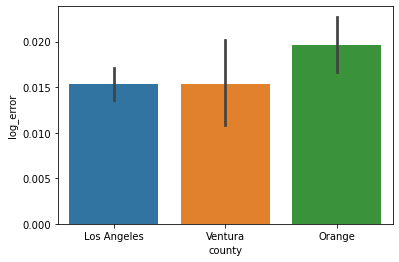

In [9]:
# Plot to view the mean log error for each county
sns.barplot(x="county", y="log_error", data=train);

In [10]:
# get statistical test results from t-test
t, p = ttest_ind(train[train.county == 'Ventura'].log_error, train[train.county == 'Los Angeles'].log_error, equal_var=False)
print(f"t: {t}\np-value: {p}")

t: 0.011601691069976671
p-value: 0.9907438540390221


#### Take Away
- With a p-value greater than the significance level, we fail to reject the null and say that the two means are about equal.

#### Question 4
<p>Is there a linear relationship between tax amount and log error?</p>

- $H_0$: tax_amount and log_error are not linearly related.
- $H_a$: tax_amount and log_error are linearly related.

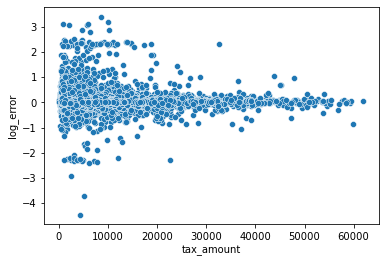

In [11]:
# plot of tax amount and log error
sns.scatterplot(x="tax_amount", y="log_error", data=train);

In [12]:
# get statistical test results from pearsonr
r, p = pearsonr(x=train.tax_amount, y=train.log_error)
print(f"r: {r}\np-value: {p}")

r: -0.0004495219979478339
p-value: 0.9221442669347352


#### Take Away
- With a p-value greater than the significance level, we fail to reject the null and say that there doesn't appear to be a linear relationship between tax amount and log error

#### Key Take Aways
- There is some colinearity between features that needs to be addressed
- There appears to exist a linear relationship between home size and log error
- While the mean log error for Orange Countyy is the largest, it appears that the mean log errors for Los Angeles and Ventura Counties are about equal.
- There does not appear to be a linear relationship between tax amount and log error

### Predicting Zillow's Log Error
- I will use Linear Regression, Lasso Regression, Ridge Regression, and Tweedie Regressor. I will pick the best model using Root Mean Squared Error, because I am concerned with how close my models can predict to the actual log error.

### Baseline
- My baseline prediction will be predicting the mean log error and examining the residuals rounded to three decimals places.

In [13]:
# import mean square error from sklearn
from sklearn.metrics import mean_squared_error

# create dataframe of y_train and add the baseline predictions to it.
act_pred_error = pd.DataFrame({"actual": y_train_no_clust})
act_pred_error["baseline_prediction"] = y_train_no_clust.mean()

# get the RMSE for the actual log error and baseline predictions
baseline_rmse = mean_squared_error(act_pred_error["actual"], act_pred_error["baseline_prediction"], squared=False)
print(f"Baseline RMSE: {round(baseline_rmse, 3)}")

Baseline RMSE: 0.166


### Models
- A grid search was performed on each algorithm to find the best hyper parameters. The Linear Regressor performed the best with a RMSE, on training, of 0.165 and 0.168, on validation, both rounded to three decimals places.

In [14]:
# Import Regression Modules
from sklearn.linear_model import Lasso, Ridge, TweedieRegressor, LinearRegression

# TRAINING SET
# Fit The Models
lasso = Lasso(alpha=0.25, random_state=123, warm_start=True).fit(X_train_no_clust, y_train_no_clust)
ridge = Ridge(alpha=1.0, random_state=123).fit(X_train_no_clust, y_train_no_clust)
tweedie = TweedieRegressor(alpha=1.0, power=0, warm_start=True).fit(X_train_no_clust, y_train_no_clust)
lr = LinearRegression().fit(X_train_no_clust, y_train_no_clust)

# Predicting Using X_train
lass_pred_train = lasso.predict(X_train_no_clust)
ridge_pred_train = ridge.predict(X_train_no_clust)
tweed_pred_train = tweedie.predict(X_train_no_clust)
lr_pred_train = lr.predict(X_train_no_clust)

print(f"lasso train rmse: {round(mean_squared_error(y_train_no_clust, lass_pred_train, squared=False), 2)}\nridge train rmse: {round(mean_squared_error(y_train_no_clust, ridge_pred_train, squared=False), 2)}\ntweedie train rmse: {round(mean_squared_error(y_train_no_clust, tweed_pred_train, squared=False), 2)}\nlr train rmse: {round(mean_squared_error(y_train_no_clust, lr_pred_train, squared=False), 3)}")

lasso train rmse: 0.17
ridge train rmse: 0.17
tweedie train rmse: 0.17
lr train rmse: 0.165


In [15]:
# VALIDATION SET

# Predicting Using X_validate
lass_pred_val = lasso.predict(X_validate_no_clust)
ridge_pred_val = ridge.predict(X_validate_no_clust)
tweed_pred_val = tweedie.predict(X_validate_no_clust)
lr_pred_val = lr.predict(X_validate_no_clust)

print(f"lasso validation rmse: {round(mean_squared_error(y_validate_no_clust, lass_pred_val, squared=False), 2)}\nridge validation rmse: {round(mean_squared_error(y_validate_no_clust, ridge_pred_val, squared=False), 2)}\ntweedie validation rmse: {round(mean_squared_error(y_validate_no_clust, tweed_pred_val, squared=False), 2)}\nlr validation rmse: {round( mean_squared_error(y_validate_no_clust, lr_pred_val, squared=False), 3)}")

lasso validation rmse: 0.17
ridge validation rmse: 0.17
tweedie validation rmse: 0.17
lr validation rmse: 0.168


- Neither model appears to be overfit. Linear Regression edges out the others.

### Clustering
- At this point feature engineering was performed using KMeans Clustering, to determine if these extra features help our models.
- We performed clustering in three groups based on home location, design, and tax prices. After some visualizations and statistical tests, it was determined that we would only move forward with the home design clusters.
- The Elbow Method was used to determine our number of clusters.
- Please see clustering notebook for further details.

In [16]:
# Import Modules for Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Create X, y for clustering
cols_dummy = ["county"]
cols_drop = ["transaction_date", "log_error"]
(X_train_clust, y_train_clust), (X_validate_clust, y_validate_clust), (X_test_clust, y_test_clust) = sgs.get_Xy(train, validate, test, cols_dummy, cols_drop)

# Scaled New Datasets
X_train_clust_scaled, X_val_clust_scaled, X_test_clust_scaled, _ = sgs.scale(X_train_clust, X_validate_clust, X_test_clust)

In [17]:
# Define Home Features and create those dataframes
home_features = ['bathroom_count', 'bedroom_count', 'home_size_square_feet', 'lot_size_square_feet']
clusters_train_scaled = X_train_clust_scaled[home_features]
clusters_validate_scaled = X_val_clust_scaled[home_features]
clusters_test_scaled = X_test_clust_scaled[home_features]

In [18]:
# Create and fit KMeans
kmeans = KMeans(n_clusters=4, max_iter=500)
kmeans.fit(clusters_train_scaled)

# Predict on train, validate, test
y_km_train = kmeans.predict(clusters_train_scaled)
y_km_val = kmeans.predict(clusters_validate_scaled)
y_km_test = kmeans.predict(clusters_test_scaled)

# Create column in scaled dataframe for kmeans
X_train_clust_scaled['home_features_cluster'] = y_km_train
X_val_clust_scaled['home_features_cluster'] = y_km_val
X_test_clust_scaled['home_features_cluster'] = y_km_test

#### Cluster Visualization and Statistical Tests

#### Question 5
<p>Are the differences in the mean log errors between clusters significant?</p>

- $H_o$: all 5 groups have the same population mean
- $H_a$: at least 1 has different mean

In [1]:
# plot of home features clusters and log error
sns.barplot(x=X_train_clust_scaled["home_features_cluster"], y=y_train_clust)

NameError: name 'sns' is not defined

In [2]:
# Concat X train and y train for statistical tests
new_train_clusters = pd.concat([X_train_clust_scaled, y_train_clust])

homef_cluster_0 = new_train_clusters["log_error"][new_train_clusters["home_features_cluster"] == 0]
homef_cluster_1 = new_train_clusters["log_error"][new_train_clusters["home_features_cluster"] == 1]
homef_cluster_2 = new_train_clusters["log_error"][new_train_clusters["home_features_cluster"] == 2]
homef_cluster_3 = new_train_clusters["log_error"][new_train_clusters["home_features_cluster"] == 3]

f, p = f_oneway(homef_cluster_0, homef_cluster_1, homef_cluster_2, homef_cluster_3)
f, p

NameError: name 'y_train_clust' is not defined

#### Take Away
- With a p-value less than the significance level, we reject the null and say that at least one cluster has a different mean.

### Cluster Modeling

In [ ]:
# TRAINING SET
# Fit The Models
lasso = Lasso(alpha=0.25, random_state=123, warm_start=True).fit(X_train_clust_scaled, y_train_clust)
ridge = Ridge(alpha=1.0, random_state=123).fit(X_train_clust_scaled, y_train_clust)
tweedie = TweedieRegressor(alpha=1.0, power=0, warm_start=True).fit(X_train_clust_scaled, y_train_clust)
lr = LinearRegression().fit(X_train_clust_scaled, y_train_clust)

# Predicting Using X_train_clust_scaled
lass_pred_train = lasso.predict(X_train_clust_scaled)
ridge_pred_train = ridge.predict(X_train_clust_scaled)
tweed_pred_train = tweedie.predict(X_train_clust_scaled)
lr_pred_train = lr.predict(X_train_clust_scaled)

print(f"lasso train rmse: {mean_squared_error(y_train_clust, lass_pred_train, squared=False)}\nridge train rmse: {mean_squared_error(y_train_clust, ridge_pred_train, squared=False)}\ntweedie train rmse: {mean_squared_error(y_train_clust, tweed_pred_train, squared=False)}\nlr train rmse: { mean_squared_error(y_train_clust, lr_pred_train, squared=False)}")


In [ ]:
# VALIDATION SET

# Predicting Using X_val_clust_scaled
lass_pred_val = lasso.predict(X_val_clust_scaled)
ridge_pred_val = ridge.predict(X_val_clust_scaled)
tweed_pred_val = tweedie.predict(X_val_clust_scaled)
lr_pred_val = lr.predict(X_val_clust_scaled)

print(f"lasso validation rmse: {mean_squared_error(y_validate_clust, lass_pred_val, squared=False)}\nridge validation rmse: {mean_squared_error(y_validate_clust, ridge_pred_val, squared=False)}\ntweedie validation rmse: {mean_squared_error(y_validate_clust, tweed_pred_val, squared=False)}\nlr validation rmse: { mean_squared_error(y_val, lr_pred_val, squared=False)}")

- Linear Regression does better on training, but Ridge Regression does better on Validate and neither model appears overfit. We shall move forward with Linear Regression

### Conclusion
-

### Recommendations and Next Steps
-